# 特徴量エンジニアリングと臨床分類

## 目的

このノートブックでは、01_data_exploration.ipynbで生成された処理済みデータを使用して:

1. 派生変数の分布分析と可視化
2. 臨床カテゴリの生成(糖尿病、CKD、肝線維化、貧血など)
3. ドメイン内・ドメイン間の相関分析
4. 性別・年齢グループ別の特徴量分析
5. ドメイン別の特徴量完全性評価
6. 臨床フラグの共起分析
7. 強化データセットの保存

## 派生変数一覧

前処理段階で生成された8つの派生変数:

- **TC_HDL_ratio**: 総コレステロール/HDL比(心血管リスク)
- **LDL_HDL_ratio**: LDL/HDL比(脂質バランス)
- **non_HDL**: 非HDLコレステロール(TC - HDL)
- **eGFR**: 推定糸球体濾過量(CKD-EPI式、腎機能)
- **HOMA_IR**: インスリン抵抗性指数
- **FIB4**: 肝線維化指数
- **AST_ALT_ratio**: AST/ALT比(肝疾患パターン)
- **ACR**: アルブミン/クレアチニン比(腎障害マーカー)

In [1]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import yaml
import warnings

warnings.filterwarnings("ignore")

# プロジェクトルートをパスに追加
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# モデルのインポート
from src.models.metabolic_risk import MetabolicRiskModel
from src.models.renal_risk import RenalRiskModel
from src.models.hepatic_risk import HepaticRiskModel
from src.models.hematologic_risk import HematologicRiskModel

# 可視化設定
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# 日本語フォント設定（macOS対応）
plt.rcParams["font.sans-serif"] = ["Hiragino Sans", "Arial Unicode MS", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False  # マイナス記号の文字化け対策

# 設定ファイルの読み込み
config_path = project_root / "config" / "clinical_thresholds.yaml"
with open(config_path, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

print("ライブラリとモデルのインポート完了")
print(f"プロジェクトルート: {project_root}")

ライブラリとモデルのインポート完了
プロジェクトルート: /Users/s2atoru/Python/COI-NEXT-Hackathon


## 1. データの読み込み

In [2]:
# 処理済みデータの読み込み
data_path = project_root / "data" / "processed" / "nhanes_processed.csv"

if data_path.exists():
    df_processed = pd.read_csv(data_path)
    print(f"データ読み込み完了: {df_processed.shape}")
    print(f"\n列数: {len(df_processed.columns)}")
    print(f"サンプル数: {len(df_processed)}")
    print(f"\n派生変数の確認:")
    derived_features = [
        "TC_HDL_ratio",
        "LDL_HDL_ratio",
        "non_HDL",
        "eGFR",
        "HOMA_IR",
        "FIB4",
        "AST_ALT_ratio",
        "ACR",
    ]
    for feat in derived_features:
        if feat in df_processed.columns:
            print(f"  ✓ {feat}")
        else:
            print(f"  ✗ {feat} (欠損)")
else:
    print(f"エラー: {data_path} が見つかりません")
    print("先に 01_data_exploration.ipynb を実行してください")

データ読み込み完了: (9254, 693)

列数: 693
サンプル数: 9254

派生変数の確認:
  ✓ TC_HDL_ratio
  ✓ LDL_HDL_ratio
  ✓ non_HDL
  ✓ eGFR
  ✓ HOMA_IR
  ✓ FIB4
  ✓ AST_ALT_ratio
  ✓ ACR


## 2. 派生変数の分布分析

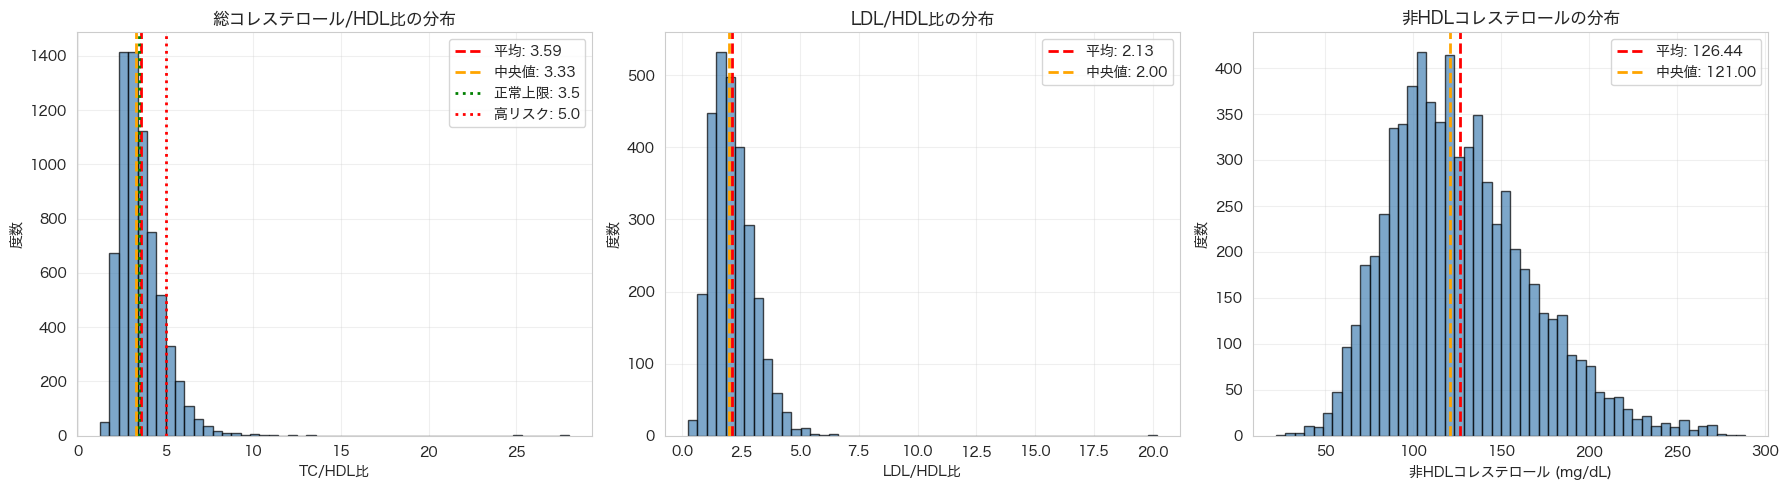

脂質比率の統計サマリー
       TC_HDL_ratio  LDL_HDL_ratio      non_HDL
count   6738.000000    2808.000000  6738.000000
mean       3.588548       2.131826   126.442670
std        1.274896       0.941506    39.873242
min        1.268293       0.245098    22.000000
25%        2.706897       1.470588    97.000000
50%        3.327273       2.000000   121.000000
75%        4.190027       2.641026   150.000000
max       28.000000      20.172273   288.315000


In [3]:
# 脂質比率の分布分析
if "df_processed" in locals():
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # TC/HDL比
    data = df_processed["TC_HDL_ratio"].dropna()
    axes[0].hist(data, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
    axes[0].axvline(
        data.mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"平均: {data.mean():.2f}",
    )
    axes[0].axvline(
        data.median(),
        color="orange",
        linestyle="--",
        linewidth=2,
        label=f"中央値: {data.median():.2f}",
    )
    axes[0].axvline(
        3.5, color="green", linestyle=":", linewidth=2, label="正常上限: 3.5"
    )
    axes[0].axvline(5.0, color="red", linestyle=":", linewidth=2, label="高リスク: 5.0")
    axes[0].set_xlabel("TC/HDL比")
    axes[0].set_ylabel("度数")
    axes[0].set_title("総コレステロール/HDL比の分布")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # LDL/HDL比
    data = df_processed["LDL_HDL_ratio"].dropna()
    axes[1].hist(data, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
    axes[1].axvline(
        data.mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"平均: {data.mean():.2f}",
    )
    axes[1].axvline(
        data.median(),
        color="orange",
        linestyle="--",
        linewidth=2,
        label=f"中央値: {data.median():.2f}",
    )
    axes[1].set_xlabel("LDL/HDL比")
    axes[1].set_ylabel("度数")
    axes[1].set_title("LDL/HDL比の分布")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # 非HDLコレステロール
    data = df_processed["non_HDL"].dropna()
    axes[2].hist(data, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
    axes[2].axvline(
        data.mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"平均: {data.mean():.2f}",
    )
    axes[2].axvline(
        data.median(),
        color="orange",
        linestyle="--",
        linewidth=2,
        label=f"中央値: {data.median():.2f}",
    )
    axes[2].set_xlabel("非HDLコレステロール (mg/dL)")
    axes[2].set_ylabel("度数")
    axes[2].set_title("非HDLコレステロールの分布")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("=" * 60)
    print("脂質比率の統計サマリー")
    print("=" * 60)
    print(df_processed[["TC_HDL_ratio", "LDL_HDL_ratio", "non_HDL"]].describe())

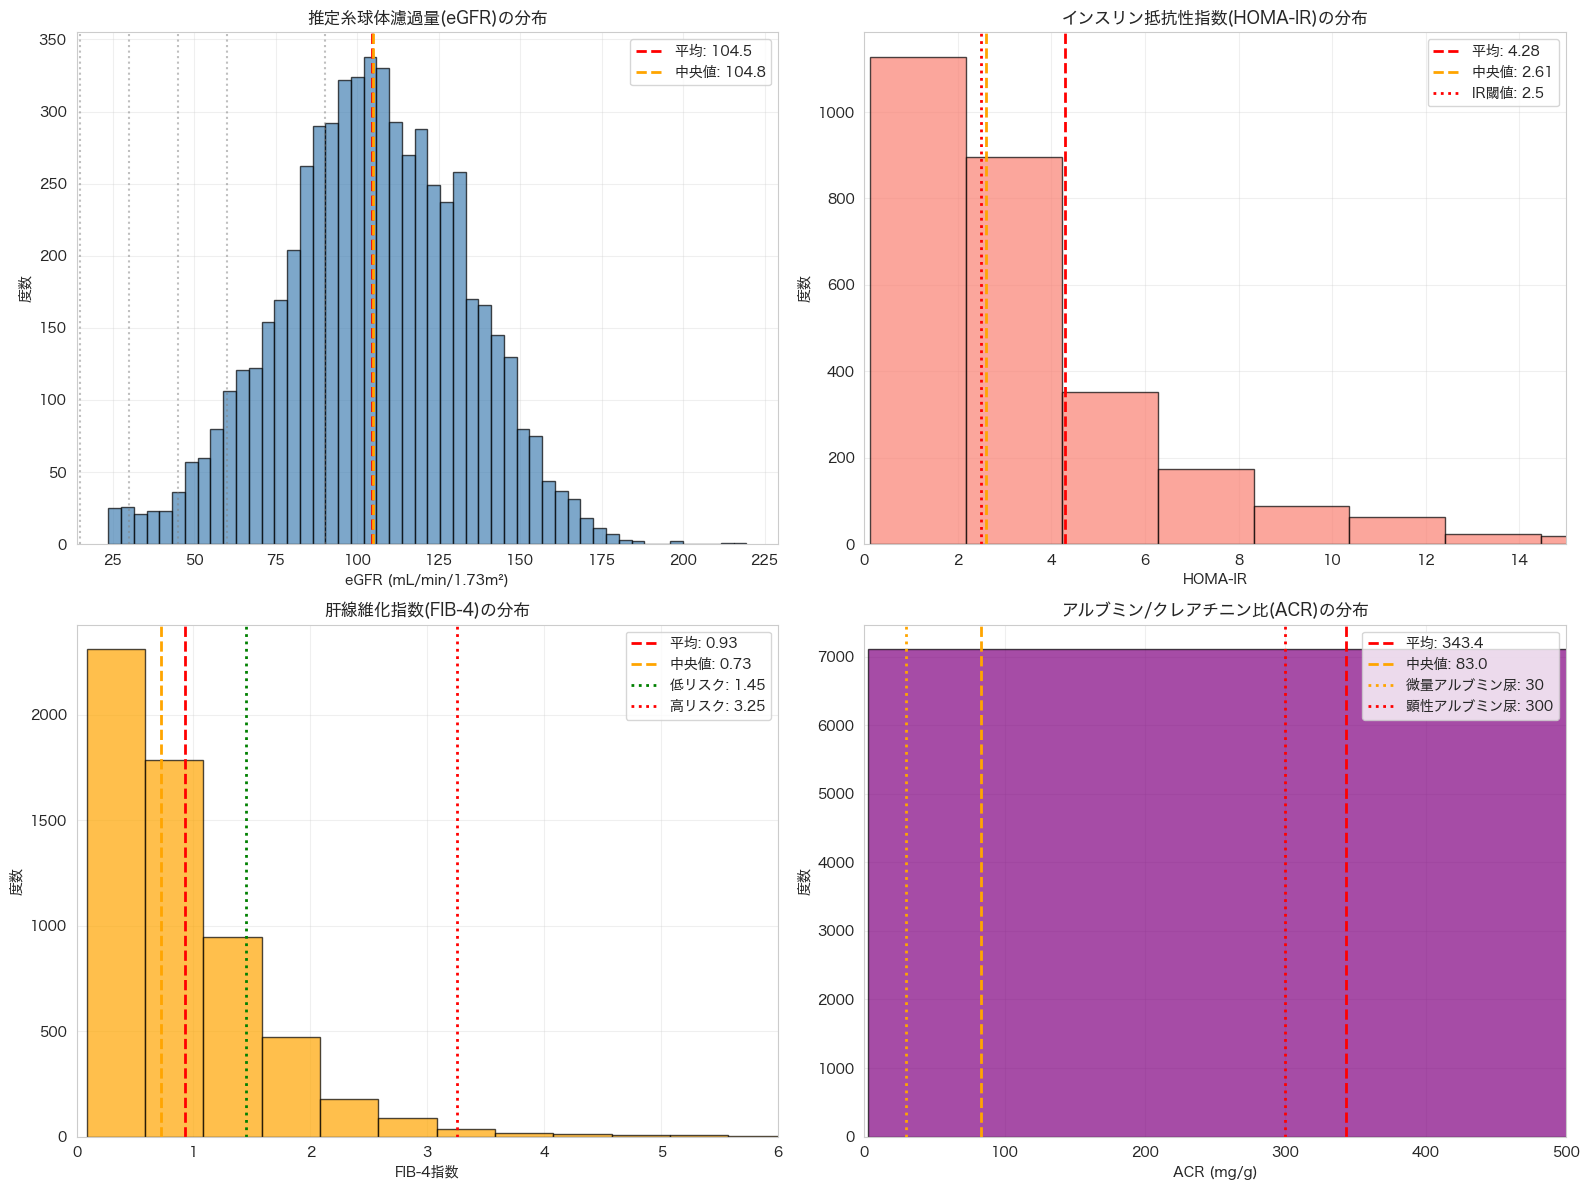

その他派生変数の統計サマリー
              eGFR      HOMA_IR         FIB4           ACR
count  5903.000000  2825.000000  5879.000000   7632.000000
mean    104.519432     4.283995     0.929628    343.393755
std      28.408678     6.492462     0.793277   1438.375494
min      23.665291     0.120963     0.087209      2.739726
25%      86.166465     1.611852     0.425429     52.380952
50%     104.750395     2.606247     0.725912     82.994216
75%     124.372393     4.612049     1.212968    158.823529
max     219.406971   102.609057    25.021730  33712.439024


In [4]:
# その他の派生変数の分布分析
if "df_processed" in locals():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # eGFR
    data = df_processed["eGFR"].dropna()
    axes[0, 0].hist(data, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
    axes[0, 0].axvline(
        data.mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"平均: {data.mean():.1f}",
    )
    axes[0, 0].axvline(
        data.median(),
        color="orange",
        linestyle="--",
        linewidth=2,
        label=f"中央値: {data.median():.1f}",
    )
    # CKDステージ境界
    for val, label in [(90, "G1"), (60, "G2"), (45, "G3a"), (30, "G3b"), (15, "G4")]:
        axes[0, 0].axvline(val, color="gray", linestyle=":", alpha=0.5)
    axes[0, 0].set_xlabel("eGFR (mL/min/1.73m²)")
    axes[0, 0].set_ylabel("度数")
    axes[0, 0].set_title("推定糸球体濾過量(eGFR)の分布")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # HOMA-IR
    data = df_processed["HOMA_IR"].dropna()
    axes[0, 1].hist(data, bins=50, color="salmon", alpha=0.7, edgecolor="black")
    axes[0, 1].axvline(
        data.mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"平均: {data.mean():.2f}",
    )
    axes[0, 1].axvline(
        data.median(),
        color="orange",
        linestyle="--",
        linewidth=2,
        label=f"中央値: {data.median():.2f}",
    )
    axes[0, 1].axvline(
        2.5, color="red", linestyle=":", linewidth=2, label="IR閾値: 2.5"
    )
    axes[0, 1].set_xlabel("HOMA-IR")
    axes[0, 1].set_ylabel("度数")
    axes[0, 1].set_title("インスリン抵抗性指数(HOMA-IR)の分布")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim(0, 15)  # 外れ値を除外して見やすく

    # FIB-4
    data = df_processed["FIB4"].dropna()
    axes[1, 0].hist(data, bins=50, color="orange", alpha=0.7, edgecolor="black")
    axes[1, 0].axvline(
        data.mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"平均: {data.mean():.2f}",
    )
    axes[1, 0].axvline(
        data.median(),
        color="orange",
        linestyle="--",
        linewidth=2,
        label=f"中央値: {data.median():.2f}",
    )
    axes[1, 0].axvline(
        1.45, color="green", linestyle=":", linewidth=2, label="低リスク: 1.45"
    )
    axes[1, 0].axvline(
        3.25, color="red", linestyle=":", linewidth=2, label="高リスク: 3.25"
    )
    axes[1, 0].set_xlabel("FIB-4指数")
    axes[1, 0].set_ylabel("度数")
    axes[1, 0].set_title("肝線維化指数(FIB-4)の分布")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim(0, 6)  # 外れ値を除外して見やすく

    # ACR
    data = df_processed["ACR"].dropna()
    axes[1, 1].hist(data, bins=50, color="purple", alpha=0.7, edgecolor="black")
    axes[1, 1].axvline(
        data.mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"平均: {data.mean():.1f}",
    )
    axes[1, 1].axvline(
        data.median(),
        color="orange",
        linestyle="--",
        linewidth=2,
        label=f"中央値: {data.median():.1f}",
    )
    axes[1, 1].axvline(
        30, color="orange", linestyle=":", linewidth=2, label="微量アルブミン尿: 30"
    )
    axes[1, 1].axvline(
        300, color="red", linestyle=":", linewidth=2, label="顕性アルブミン尿: 300"
    )
    axes[1, 1].set_xlabel("ACR (mg/g)")
    axes[1, 1].set_ylabel("度数")
    axes[1, 1].set_title("アルブミン/クレアチニン比(ACR)の分布")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim(0, 500)  # 外れ値を除外して見やすく

    plt.tight_layout()
    plt.show()

    print("=" * 60)
    print("その他派生変数の統計サマリー")
    print("=" * 60)
    print(df_processed[["eGFR", "HOMA_IR", "FIB4", "ACR"]].describe())

## 3. 臨床カテゴリの生成

In [5]:
# モデルの初期化と臨床カテゴリの生成
if "df_processed" in locals():
    df_enhanced = df_processed.copy()

    # モデルのインスタンス化
    metabolic_model = MetabolicRiskModel()
    renal_model = RenalRiskModel()
    hepatic_model = HepaticRiskModel()
    hematologic_model = HematologicRiskModel()

    print("臨床カテゴリの生成中...")
    print("=" * 60)

    # 糖尿病ステータス
    df_enhanced["diabetes_status"] = df_enhanced.apply(
        lambda row: metabolic_model.assess_diabetes_status(row), axis=1
    )
    df_enhanced["diabetes_flag"] = (
        df_enhanced["diabetes_status"].isin(["prediabetes", "diabetes"]).astype(int)
    )

    # CKDステージ
    ckd_results = df_enhanced.apply(
        lambda row: renal_model.assess_ckd_stage(row), axis=1
    )
    df_enhanced["ckd_gfr_stage"] = ckd_results.apply(
        lambda x: x.get("gfr_category", "unknown")
    )
    df_enhanced["ckd_albuminuria_stage"] = ckd_results.apply(
        lambda x: x.get("albuminuria_category", "unknown")
    )
    df_enhanced["ckd_flag"] = (df_enhanced["eGFR"] < 60).astype(int)

    # 肝線維化リスク
    df_enhanced["fibrosis_risk"] = df_enhanced.apply(
        lambda row: hepatic_model.assess_fibrosis_risk(row), axis=1
    )
    df_enhanced["fibrosis_flag"] = (
        df_enhanced["fibrosis_risk"].isin(["intermediate", "high"]).astype(int)
    )

    # 貧血タイプ
    df_enhanced["anemia_type"] = df_enhanced.apply(
        lambda row: hematologic_model.classify_anemia_type(row), axis=1
    )
    df_enhanced["anemia_flag"] = (df_enhanced["anemia_type"] != "normal").astype(int)

    # 脂質異常症フラグ
    df_enhanced["high_ldl_flag"] = (df_enhanced["LBDLDL"] >= 160).astype(int)
    df_enhanced["low_hdl_flag"] = (
        ((df_enhanced["RIAGENDR"] == 1) & (df_enhanced["LBDHDD"] < 40))
        | ((df_enhanced["RIAGENDR"] == 2) & (df_enhanced["LBDHDD"] < 50))
    ).astype(int)
    df_enhanced["high_tg_flag"] = (df_enhanced["LBXTR"] >= 200).astype(int)
    df_enhanced["dyslipidemia_flag"] = (
        (df_enhanced["high_ldl_flag"] == 1)
        | (df_enhanced["low_hdl_flag"] == 1)
        | (df_enhanced["high_tg_flag"] == 1)
    ).astype(int)

    # インスリン抵抗性フラグ
    df_enhanced["insulin_resistance_flag"] = (df_enhanced["HOMA_IR"] >= 2.5).astype(int)

    print("\n臨床カテゴリのサマリー:")
    print("=" * 60)

    # 糖尿病ステータス
    print("\n【糖尿病ステータス】")
    status_counts = df_enhanced["diabetes_status"].value_counts()
    for status, count in status_counts.items():
        pct = count / len(df_enhanced) * 100
        print(f"  {status}: {count} ({pct:.1f}%)")

    # CKDステージ
    print("\n【CKD GFRステージ】")
    stage_counts = df_enhanced["ckd_gfr_stage"].value_counts()
    for stage, count in stage_counts.items():
        pct = count / len(df_enhanced) * 100
        print(f"  {stage}: {count} ({pct:.1f}%)")

    # 肝線維化リスク
    print("\n【肝線維化リスク】")
    fib_counts = df_enhanced["fibrosis_risk"].value_counts()
    for risk, count in fib_counts.items():
        pct = count / len(df_enhanced) * 100
        print(f"  {risk}: {count} ({pct:.1f}%)")

    # 貧血タイプ
    print("\n【貧血タイプ】")
    anemia_counts = df_enhanced["anemia_type"].value_counts()
    for atype, count in anemia_counts.items():
        pct = count / len(df_enhanced) * 100
        print(f"  {atype}: {count} ({pct:.1f}%)")

    # バイナリフラグサマリー
    print("\n【臨床フラグサマリー】")
    flag_columns = [
        "diabetes_flag",
        "ckd_flag",
        "fibrosis_flag",
        "anemia_flag",
        "dyslipidemia_flag",
        "insulin_resistance_flag",
    ]
    for flag in flag_columns:
        count = df_enhanced[flag].sum()
        pct = count / len(df_enhanced) * 100
        print(f"  {flag}: {count} ({pct:.1f}%)")

臨床カテゴリの生成中...

臨床カテゴリのサマリー:

【糖尿病ステータス】
  insufficient_data: 3205 (34.6%)
  normal: 2892 (31.3%)
  prediabetes: 2292 (24.8%)
  diabetes: 865 (9.3%)

【CKD GFRステージ】
  unknown: 9254 (100.0%)

【肝線維化リスク】
  low: 4833 (52.2%)
  insufficient_data: 3375 (36.5%)
  intermediate: 969 (10.5%)
  high: 77 (0.8%)

【貧血タイプ】
  normocytic: 1553 (16.8%)
  microcytic: 704 (7.6%)
  macrocytic: 16 (0.2%)

【臨床フラグサマリー】
  diabetes_flag: 3157 (34.1%)
  ckd_flag: 380 (4.1%)
  fibrosis_flag: 1046 (11.3%)
  anemia_flag: 9254 (100.0%)
  dyslipidemia_flag: 412 (4.5%)
  insulin_resistance_flag: 1481 (16.0%)


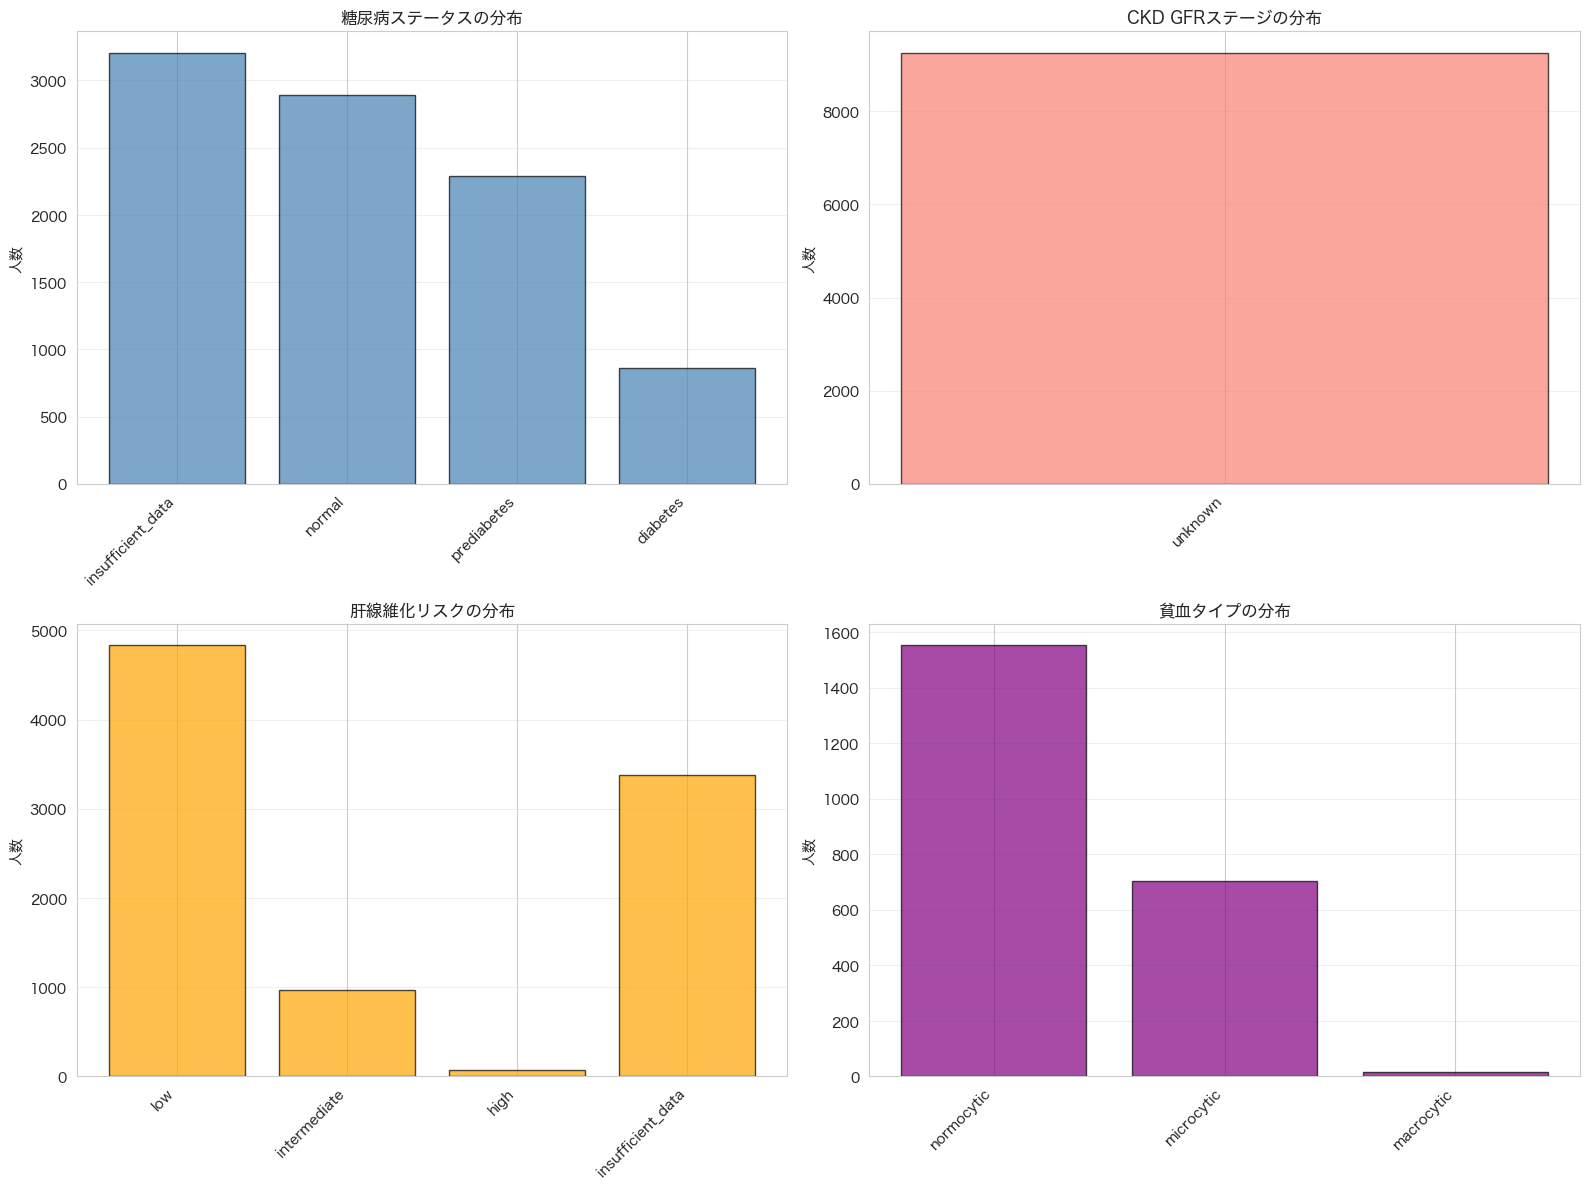

In [6]:
# 臨床カテゴリの分布可視化
if "df_enhanced" in locals():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 糖尿病ステータス
    status_counts = df_enhanced["diabetes_status"].value_counts()
    axes[0, 0].bar(
        range(len(status_counts)),
        status_counts.values,
        color="steelblue",
        alpha=0.7,
        edgecolor="black",
    )
    axes[0, 0].set_xticks(range(len(status_counts)))
    axes[0, 0].set_xticklabels(status_counts.index, rotation=45, ha="right")
    axes[0, 0].set_ylabel("人数")
    axes[0, 0].set_title("糖尿病ステータスの分布")
    axes[0, 0].grid(True, alpha=0.3, axis="y")

    # CKD GFRステージ
    stage_order = ["G1", "G2", "G3a", "G3b", "G4", "G5", "unknown"]
    stage_counts = df_enhanced["ckd_gfr_stage"].value_counts()
    stage_counts = stage_counts.reindex(
        [s for s in stage_order if s in stage_counts.index], fill_value=0
    )
    axes[0, 1].bar(
        range(len(stage_counts)),
        stage_counts.values,
        color="salmon",
        alpha=0.7,
        edgecolor="black",
    )
    axes[0, 1].set_xticks(range(len(stage_counts)))
    axes[0, 1].set_xticklabels(stage_counts.index, rotation=45, ha="right")
    axes[0, 1].set_ylabel("人数")
    axes[0, 1].set_title("CKD GFRステージの分布")
    axes[0, 1].grid(True, alpha=0.3, axis="y")

    # 肝線維化リスク
    risk_order = ["low", "intermediate", "high", "insufficient_data"]
    fib_counts = df_enhanced["fibrosis_risk"].value_counts()
    fib_counts = fib_counts.reindex(
        [r for r in risk_order if r in fib_counts.index], fill_value=0
    )
    axes[1, 0].bar(
        range(len(fib_counts)),
        fib_counts.values,
        color="orange",
        alpha=0.7,
        edgecolor="black",
    )
    axes[1, 0].set_xticks(range(len(fib_counts)))
    axes[1, 0].set_xticklabels(fib_counts.index, rotation=45, ha="right")
    axes[1, 0].set_ylabel("人数")
    axes[1, 0].set_title("肝線維化リスクの分布")
    axes[1, 0].grid(True, alpha=0.3, axis="y")

    # 貧血タイプ
    anemia_counts = df_enhanced["anemia_type"].value_counts()
    axes[1, 1].bar(
        range(len(anemia_counts)),
        anemia_counts.values,
        color="purple",
        alpha=0.7,
        edgecolor="black",
    )
    axes[1, 1].set_xticks(range(len(anemia_counts)))
    axes[1, 1].set_xticklabels(anemia_counts.index, rotation=45, ha="right")
    axes[1, 1].set_ylabel("人数")
    axes[1, 1].set_title("貧血タイプの分布")
    axes[1, 1].grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()

## 4. ドメイン内・ドメイン間相関分析

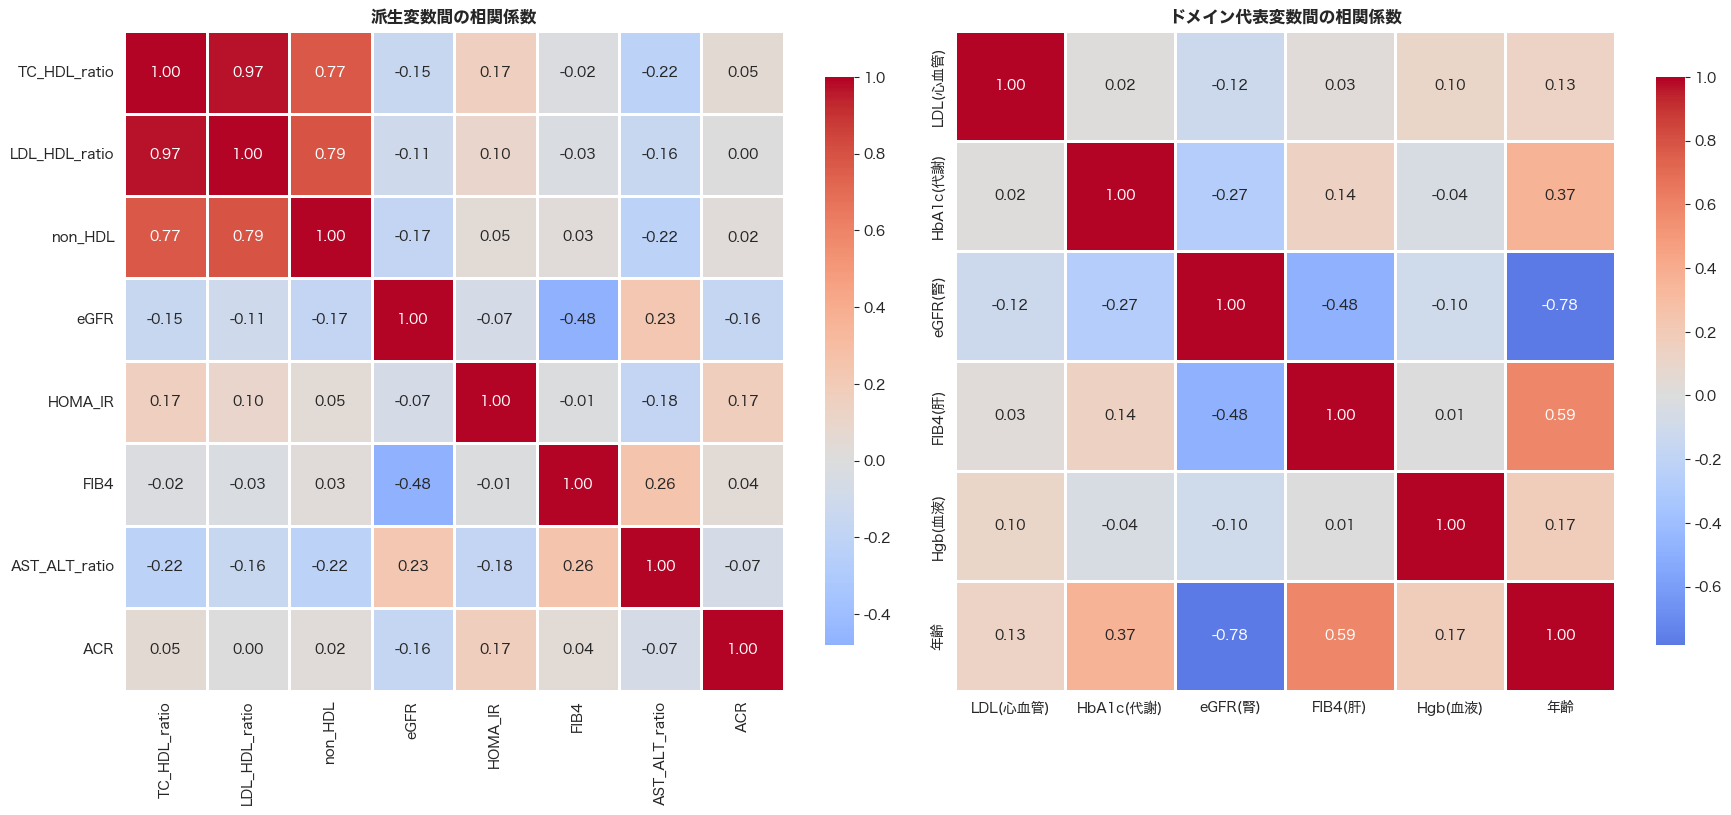

主要な相関関係

【派生変数】
  TC_HDL_ratio ↔ LDL_HDL_ratio: 0.967
  LDL_HDL_ratio ↔ non_HDL: 0.793
  TC_HDL_ratio ↔ non_HDL: 0.775
  eGFR ↔ FIB4: -0.481


In [7]:
# 相関分析
if "df_enhanced" in locals():
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # 派生変数間の相関
    derived_features = [
        "TC_HDL_ratio",
        "LDL_HDL_ratio",
        "non_HDL",
        "eGFR",
        "HOMA_IR",
        "FIB4",
        "AST_ALT_ratio",
        "ACR",
    ]
    corr_derived = df_enhanced[derived_features].corr()

    sns.heatmap(
        corr_derived,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        linewidths=1,
        cbar_kws={"shrink": 0.8},
        ax=axes[0],
    )
    axes[0].set_title("派生変数間の相関係数", fontsize=12, fontweight="bold")

    # ドメイン代表変数間の相関
    domain_features = {
        "LBDLDL": "LDL(心血管)",
        "LBXGH": "HbA1c(代謝)",
        "eGFR": "eGFR(腎)",
        "FIB4": "FIB4(肝)",
        "LBXHGB": "Hgb(血液)",
        "RIDAGEYR": "年齢",
    }
    corr_domain = df_enhanced[list(domain_features.keys())].corr()
    corr_domain.index = [domain_features[col] for col in corr_domain.index]
    corr_domain.columns = [domain_features[col] for col in corr_domain.columns]

    sns.heatmap(
        corr_domain,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        linewidths=1,
        cbar_kws={"shrink": 0.8},
        ax=axes[1],
    )
    axes[1].set_title("ドメイン代表変数間の相関係数", fontsize=12, fontweight="bold")

    plt.tight_layout()
    plt.show()

    print("=" * 60)
    print("主要な相関関係")
    print("=" * 60)
    print("\n【派生変数】")
    # 相関の絶対値が0.3以上のペアを抽出
    high_corr = []
    for i in range(len(derived_features)):
        for j in range(i + 1, len(derived_features)):
            corr_val = corr_derived.iloc[i, j]
            if abs(corr_val) >= 0.3:
                high_corr.append((derived_features[i], derived_features[j], corr_val))
    high_corr.sort(key=lambda x: abs(x[2]), reverse=True)
    for feat1, feat2, corr_val in high_corr[:10]:
        print(f"  {feat1} ↔ {feat2}: {corr_val:.3f}")

## 5. 性別・年齢グループ別分析

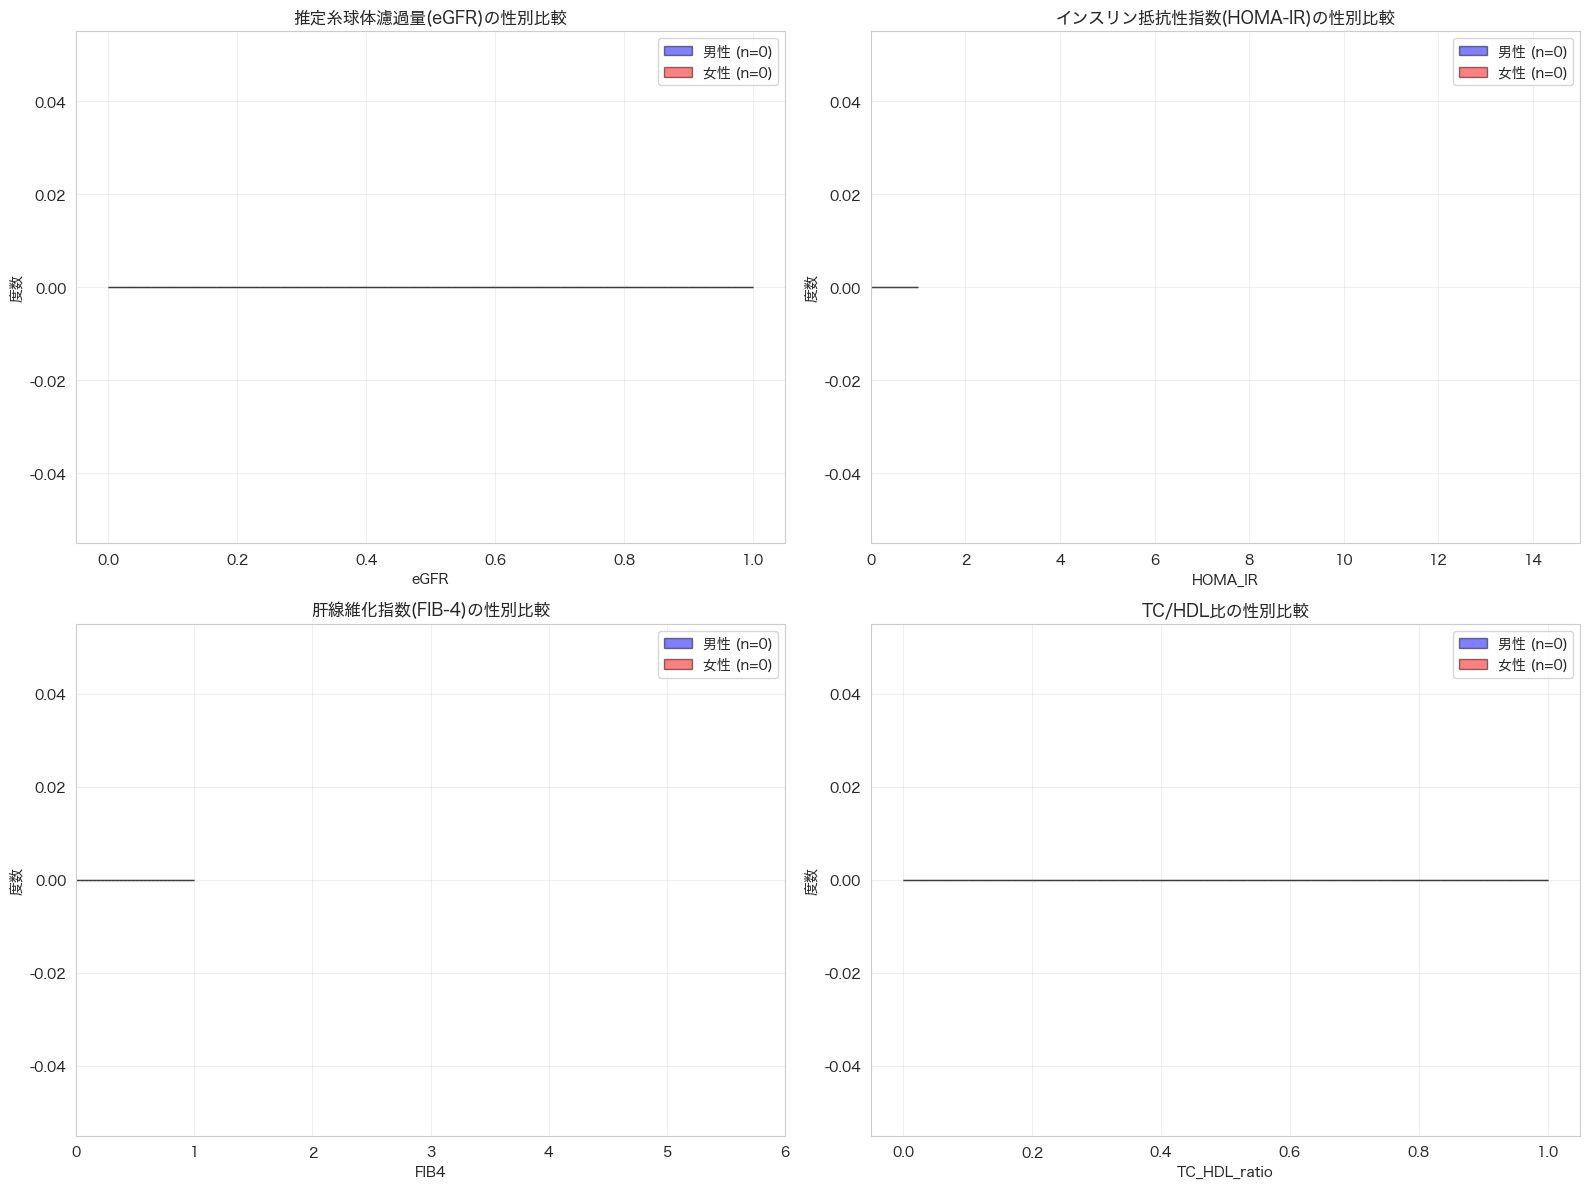

In [8]:
# 性別別の分布比較
if "df_enhanced" in locals():
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    features_to_plot = [
        ("eGFR", "推定糸球体濾過量(eGFR)"),
        ("HOMA_IR", "インスリン抵抗性指数(HOMA-IR)"),
        ("FIB4", "肝線維化指数(FIB-4)"),
        ("TC_HDL_ratio", "TC/HDL比"),
    ]

    for idx, (feature, title) in enumerate(features_to_plot):
        ax = axes[idx // 2, idx % 2]

        # 性別データの抽出
        male_data = df_enhanced[df_enhanced["RIAGENDR"] == 1][feature].dropna()
        female_data = df_enhanced[df_enhanced["RIAGENDR"] == 2][feature].dropna()

        # ヒストグラムの描画
        ax.hist(
            male_data,
            bins=30,
            alpha=0.5,
            color="blue",
            label=f"男性 (n={len(male_data)})",
            edgecolor="black",
        )
        ax.hist(
            female_data,
            bins=30,
            alpha=0.5,
            color="red",
            label=f"女性 (n={len(female_data)})",
            edgecolor="black",
        )

        ax.axvline(
            male_data.mean(), color="blue", linestyle="--", linewidth=2, alpha=0.7
        )
        ax.axvline(
            female_data.mean(), color="red", linestyle="--", linewidth=2, alpha=0.7
        )

        ax.set_xlabel(feature)
        ax.set_ylabel("度数")
        ax.set_title(f"{title}の性別比較")
        ax.legend()
        ax.grid(True, alpha=0.3)

        # FIB-4とHOMA-IRは外れ値が多いのでx軸を制限
        if feature == "FIB4":
            ax.set_xlim(0, 6)
        elif feature == "HOMA_IR":
            ax.set_xlim(0, 15)

    plt.tight_layout()
    plt.show()

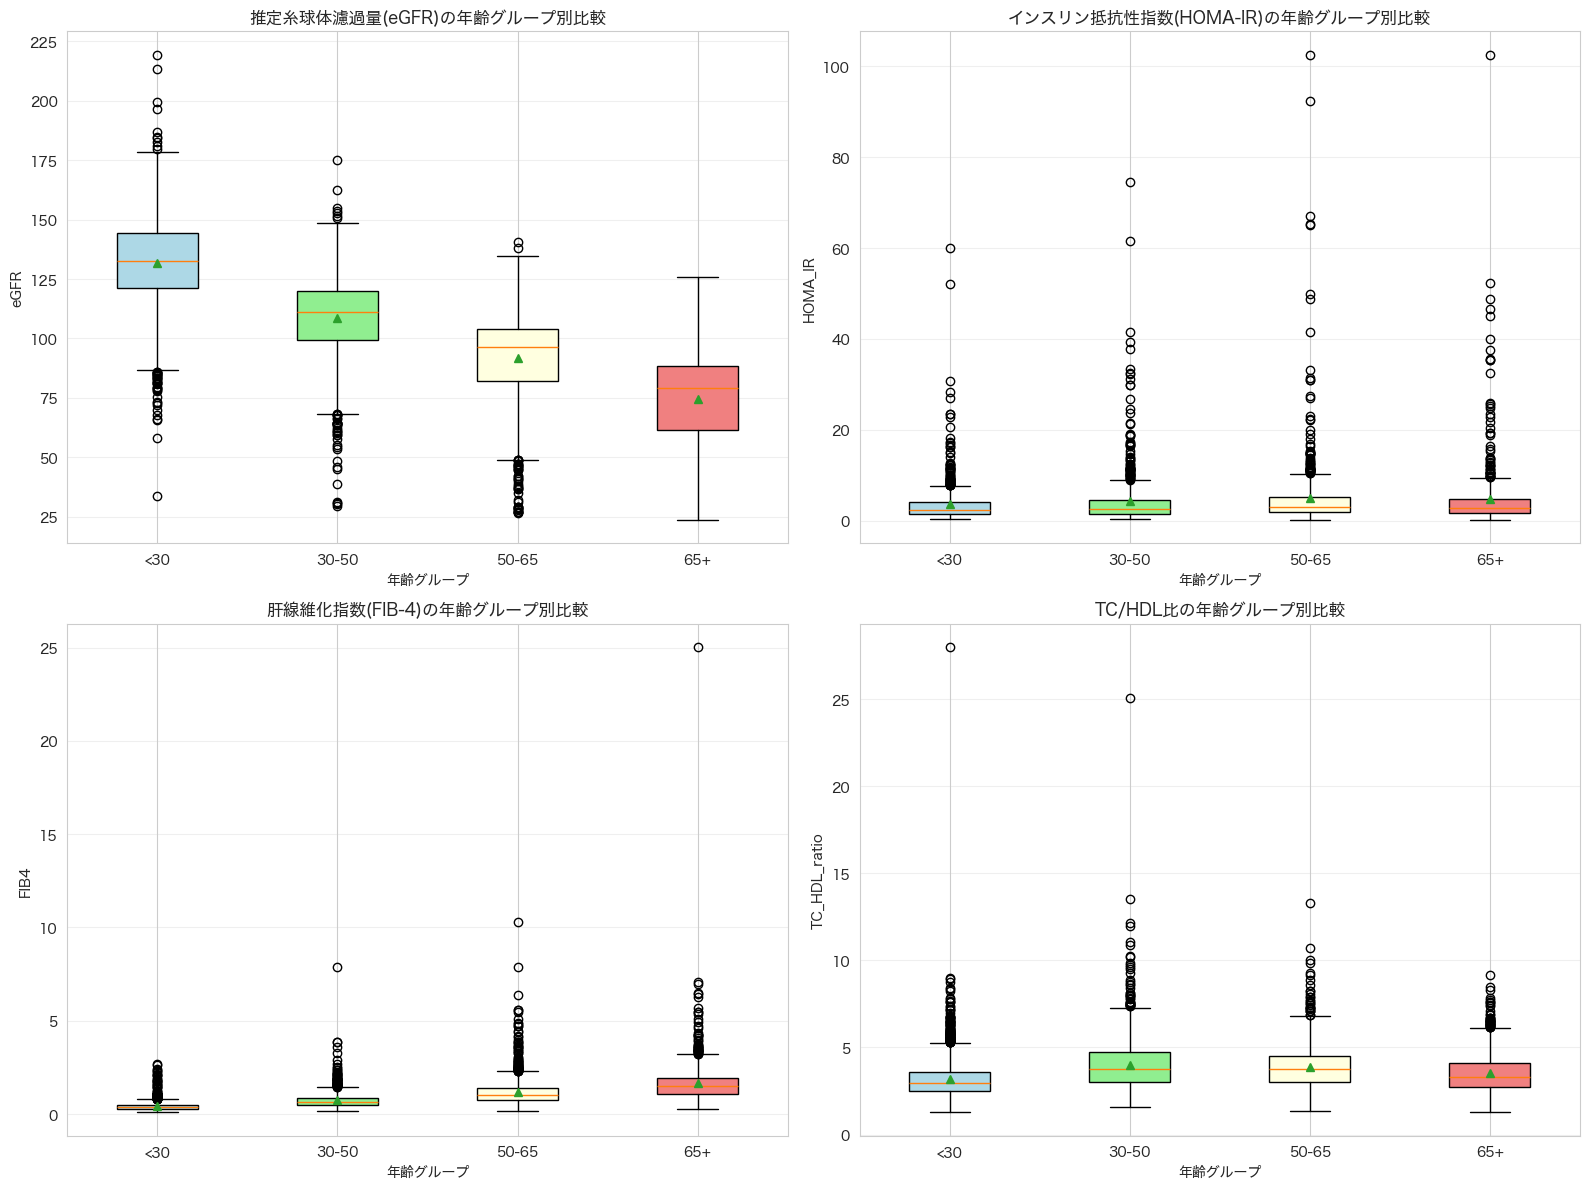

In [9]:
# 年齢グループ別の分布比較
if "df_enhanced" in locals():
    # 年齢グループの作成
    df_enhanced["age_group"] = pd.cut(
        df_enhanced["RIDAGEYR"],
        bins=[0, 30, 50, 65, 100],
        labels=["<30", "30-50", "50-65", "65+"],
    )

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    for idx, (feature, title) in enumerate(features_to_plot):
        ax = axes[idx // 2, idx % 2]

        # 年齢グループごとのデータ
        data_by_age = [
            df_enhanced[df_enhanced["age_group"] == age][feature].dropna()
            for age in ["<30", "30-50", "50-65", "65+"]
        ]

        bp = ax.boxplot(
            data_by_age,
            labels=["<30", "30-50", "50-65", "65+"],
            patch_artist=True,
            showmeans=True,
        )

        # ボックスプロットの色設定
        colors = ["lightblue", "lightgreen", "lightyellow", "lightcoral"]
        for patch, color in zip(bp["boxes"], colors):
            patch.set_facecolor(color)

        ax.set_xlabel("年齢グループ")
        ax.set_ylabel(feature)
        ax.set_title(f"{title}の年齢グループ別比較")
        ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()

## 6. ドメイン別特徴量完全性の評価

ドメイン別特徴量完全性評価

【cardiovascular】
  必要変数: LBDLDL, LBDHDD, LBXTR, TC_HDL_ratio, LBXTC
  完全ケース: 2808 (30.3%)
  部分ケース: 3930 (42.5%)
  欠損ケース: 2516 (27.2%)

【metabolic】
  必要変数: LBXGLU, LBXGH, HOMA_IR, LBXIN
  完全ケース: 2822 (30.5%)
  部分ケース: 3227 (34.9%)
  欠損ケース: 3205 (34.6%)

【renal】
  必要変数: eGFR, ACR, LBXSCR
  完全ケース: 5800 (62.7%)
  部分ケース: 1935 (20.9%)
  欠損ケース: 1519 (16.4%)

【hepatic】
  必要変数: LBXSASSI, LBXSGTSI, FIB4, AST_ALT_ratio, LBXSAL, LBXSTB
  完全ケース: 5879 (63.5%)
  部分ケース: 26 (0.3%)
  欠損ケース: 3349 (36.2%)

【hematologic】
  必要変数: LBXHGB, LBXWBCSI, LBXPLTSI, LBXMCVSI
  完全ケース: 7528 (81.3%)
  部分ケース: 0 (0.0%)
  欠損ケース: 1726 (18.7%)


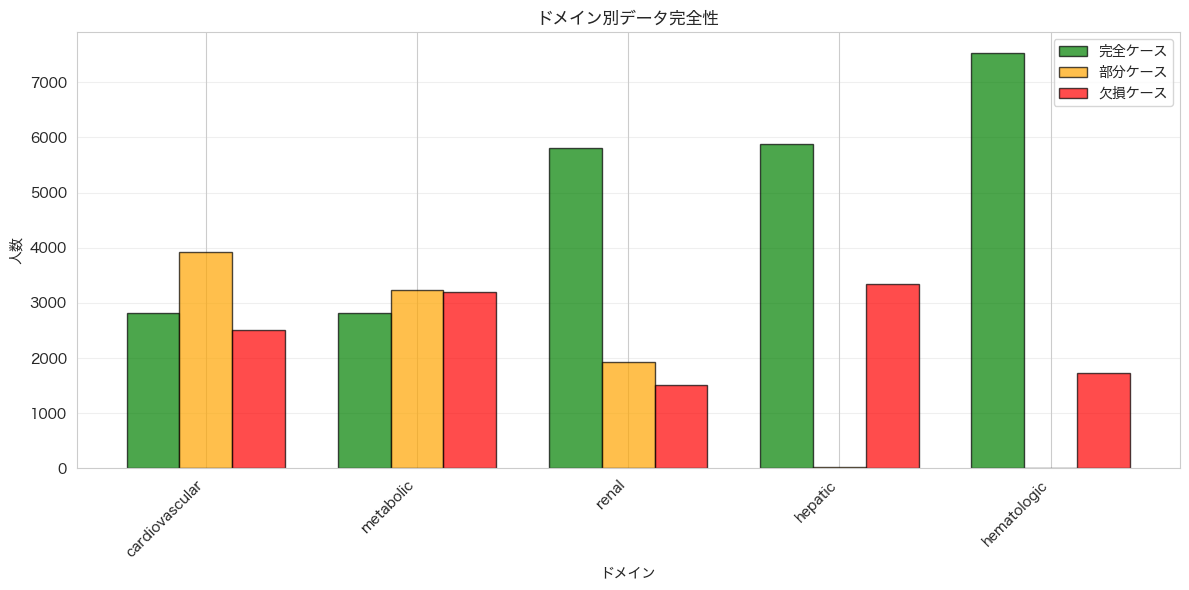

In [10]:
# ドメイン別の特徴量完全性評価
if "df_enhanced" in locals():
    # 各ドメインの必須変数を定義
    domain_features = {
        "cardiovascular": ["LBDLDL", "LBDHDD", "LBXTR", "TC_HDL_ratio", "LBXTC"],
        "metabolic": ["LBXGLU", "LBXGH", "HOMA_IR", "LBXIN"],
        "renal": ["eGFR", "ACR", "LBXSCR"],
        "hepatic": [
            "LBXSASSI",
            "LBXSGTSI",
            "FIB4",
            "AST_ALT_ratio",
            "LBXSAL",
            "LBXSTB",
        ],
        "hematologic": ["LBXHGB", "LBXWBCSI", "LBXPLTSI", "LBXMCVSI"],
    }

    completeness_results = {}

    print("=" * 60)
    print("ドメイン別特徴量完全性評価")
    print("=" * 60)

    for domain, features in domain_features.items():
        # 実際に存在する変数のみを使用
        available_features = [f for f in features if f in df_enhanced.columns]

        if not available_features:
            print(f"\n【{domain}】")
            print("  利用可能な変数なし")
            continue

        # 完全ケース(全変数が揃っている)
        complete_cases = df_enhanced[available_features].notna().all(axis=1).sum()
        # 部分ケース(少なくとも1つの変数が揃っている)
        partial_cases = df_enhanced[available_features].notna().any(axis=1).sum()

        completeness_results[domain] = {
            "complete": complete_cases,
            "partial": partial_cases - complete_cases,
            "missing": len(df_enhanced) - partial_cases,
        }

        print(f"\n【{domain}】")
        print(f"  必要変数: {', '.join(available_features)}")
        print(
            f"  完全ケース: {complete_cases} ({complete_cases / len(df_enhanced) * 100:.1f}%)"
        )
        print(
            f"  部分ケース: {partial_cases - complete_cases} ({(partial_cases - complete_cases) / len(df_enhanced) * 100:.1f}%)"
        )
        print(
            f"  欠損ケース: {len(df_enhanced) - partial_cases} ({(len(df_enhanced) - partial_cases) / len(df_enhanced) * 100:.1f}%)"
        )

    # 可視化
    fig, ax = plt.subplots(figsize=(12, 6))

    domains = list(completeness_results.keys())
    complete = [completeness_results[d]["complete"] for d in domains]
    partial = [completeness_results[d]["partial"] for d in domains]
    missing = [completeness_results[d]["missing"] for d in domains]

    x = np.arange(len(domains))
    width = 0.25

    ax.bar(
        x - width,
        complete,
        width,
        label="完全ケース",
        color="green",
        alpha=0.7,
        edgecolor="black",
    )
    ax.bar(
        x,
        partial,
        width,
        label="部分ケース",
        color="orange",
        alpha=0.7,
        edgecolor="black",
    )
    ax.bar(
        x + width,
        missing,
        width,
        label="欠損ケース",
        color="red",
        alpha=0.7,
        edgecolor="black",
    )

    ax.set_xlabel("ドメイン")
    ax.set_ylabel("人数")
    ax.set_title("ドメイン別データ完全性")
    ax.set_xticks(x)
    ax.set_xticklabels(domains, rotation=45, ha="right")
    ax.legend()
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.show()

## 7. 臨床フラグの共起分析

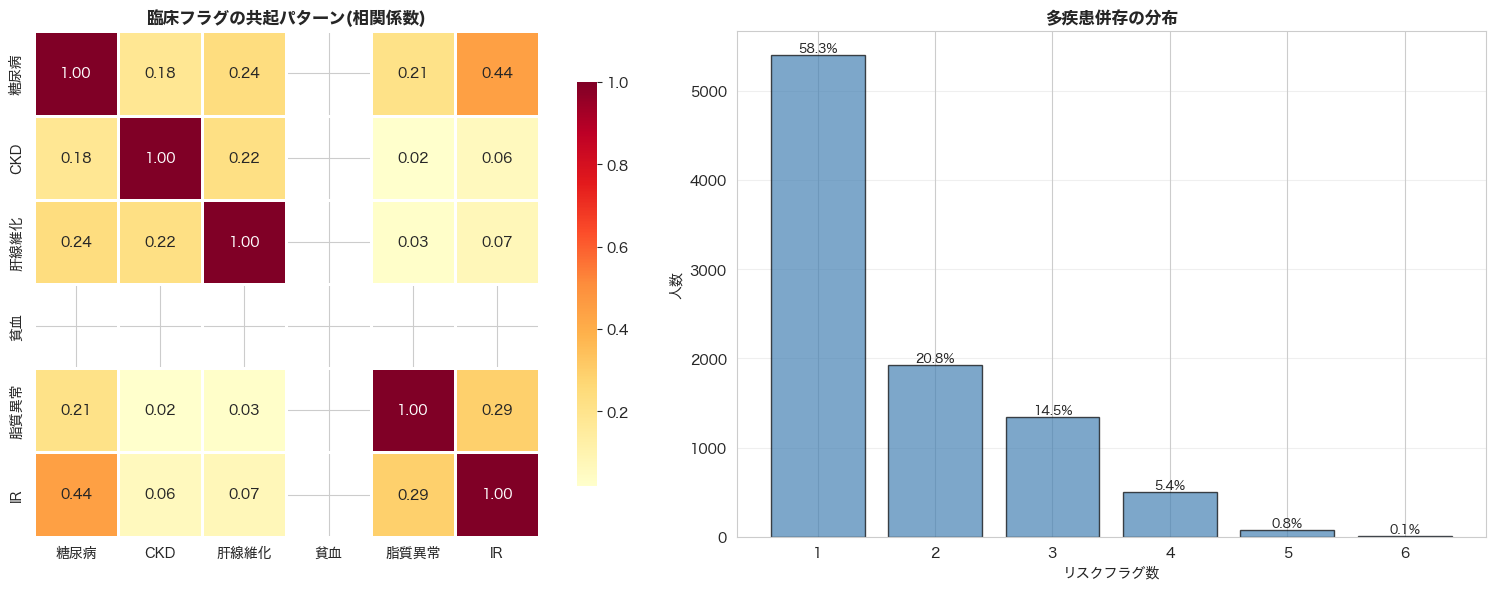

多疾患併存のサマリー
  1個のリスクフラグ: 5397 (58.3%)
  2個のリスクフラグ: 1923 (20.8%)
  3個のリスクフラグ: 1345 (14.5%)
  4個のリスクフラグ: 502 (5.4%)
  5個のリスクフラグ: 78 (0.8%)
  6個のリスクフラグ: 9 (0.1%)

  2個以上のリスクフラグを持つ患者: 3857 (41.7%)


In [11]:
# 臨床フラグの共起分析
if "df_enhanced" in locals():
    flag_columns = [
        "diabetes_flag",
        "ckd_flag",
        "fibrosis_flag",
        "anemia_flag",
        "dyslipidemia_flag",
        "insulin_resistance_flag",
    ]

    # フラグ間の相関
    flag_corr = df_enhanced[flag_columns].corr()

    # ラベルを日本語に変換
    flag_labels = {
        "diabetes_flag": "糖尿病",
        "ckd_flag": "CKD",
        "fibrosis_flag": "肝線維化",
        "anemia_flag": "貧血",
        "dyslipidemia_flag": "脂質異常",
        "insulin_resistance_flag": "IR",
    }

    flag_corr.index = [flag_labels[col] for col in flag_corr.index]
    flag_corr.columns = [flag_labels[col] for col in flag_corr.columns]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ヒートマップ
    sns.heatmap(
        flag_corr,
        annot=True,
        fmt=".2f",
        cmap="YlOrRd",
        square=True,
        linewidths=1,
        cbar_kws={"shrink": 0.8},
        ax=axes[0],
    )
    axes[0].set_title(
        "臨床フラグの共起パターン(相関係数)", fontsize=12, fontweight="bold"
    )

    # 多疾患併存の分布
    df_enhanced["multi_morbidity_count"] = df_enhanced[flag_columns].sum(axis=1)
    morbidity_counts = df_enhanced["multi_morbidity_count"].value_counts().sort_index()

    axes[1].bar(
        morbidity_counts.index,
        morbidity_counts.values,
        color="steelblue",
        alpha=0.7,
        edgecolor="black",
    )
    axes[1].set_xlabel("リスクフラグ数")
    axes[1].set_ylabel("人数")
    axes[1].set_title("多疾患併存の分布", fontsize=12, fontweight="bold")
    axes[1].grid(True, alpha=0.3, axis="y")

    # パーセンテージを追加
    for i, count in enumerate(morbidity_counts.values):
        pct = count / len(df_enhanced) * 100
        axes[1].text(
            morbidity_counts.index[i],
            count,
            f"{pct:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

    print("=" * 60)
    print("多疾患併存のサマリー")
    print("=" * 60)
    for count, num in morbidity_counts.items():
        pct = num / len(df_enhanced) * 100
        print(f"  {count}個のリスクフラグ: {num} ({pct:.1f}%)")

    print(
        f"\n  2個以上のリスクフラグを持つ患者: {(df_enhanced['multi_morbidity_count'] >= 2).sum()} "
        f"({(df_enhanced['multi_morbidity_count'] >= 2).sum() / len(df_enhanced) * 100:.1f}%)"
    )

## 8. 強化データセットの保存

In [12]:
# 強化データセットの保存
if "df_enhanced" in locals():
    output_path = project_root / "data" / "processed" / "nhanes_enhanced.csv"
    df_enhanced.to_csv(output_path, index=False)

    print("=" * 60)
    print("強化データセットの保存完了")
    print("=" * 60)
    print(f"保存先: {output_path}")
    print(f"データ形状: {df_enhanced.shape}")

    # 追加された列のリスト
    original_cols = set(df_processed.columns)
    new_cols = set(df_enhanced.columns) - original_cols

    print(f"\n追加された列 ({len(new_cols)}個):")
    for col in sorted(new_cols):
        print(f"  - {col}")

強化データセットの保存完了
保存先: /Users/s2atoru/Python/COI-NEXT-Hackathon/data/processed/nhanes_enhanced.csv
データ形状: (9254, 708)

追加された列 (15個):
  - anemia_flag
  - anemia_type
  - ckd_albuminuria_stage
  - ckd_flag
  - ckd_gfr_stage
  - diabetes_flag
  - diabetes_status
  - dyslipidemia_flag
  - fibrosis_flag
  - fibrosis_risk
  - high_ldl_flag
  - high_tg_flag
  - insulin_resistance_flag
  - low_hdl_flag
  - multi_morbidity_count


## まとめ

このノートブックで実施した内容:

1. **派生変数の分布分析**: 8つの派生変数(TC_HDL_ratio、LDL_HDL_ratio、non_HDL、eGFR、HOMA_IR、FIB4、AST_ALT_ratio、ACR)の分布を可視化し、臨床的閾値との関係を確認

2. **臨床カテゴリの生成**: ドメイン固有のモデルメソッドを使用して、糖尿病ステータス、CKDステージ、肝線維化リスク、貧血タイプ、脂質異常症フラグ、インスリン抵抗性フラグを生成

3. **相関分析**: 派生変数間およびドメイン代表変数間の相関パターンを分析し、臨床的に重要な関連性を特定

4. **性別・年齢別分析**: 主要な派生変数について性別および年齢グループ別の分布を比較し、人口統計学的な違いを確認

5. **データ完全性評価**: 各ドメインについて、完全ケース・部分ケース・欠損ケースの割合を評価し、スコアリングの信頼性を把握

6. **多疾患併存分析**: 臨床フラグの共起パターンと多疾患併存の分布を分析し、複合的なリスク保有者の特徴を把握

7. **データセット保存**: 臨床カテゴリとフラグを追加した強化データセットを`nhanes_enhanced.csv`として保存

### 次のステップ

- **03_risk_model_development.ipynb**: 複合リスクモデルの開発とスコアリング
- **04_validation_analysis.ipynb**: モデルの妥当性検証と感度分析